<a href="https://colab.research.google.com/github/Memento2121/SeaStateForcastDL/blob/main/Training_WindSpeedDL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import requests
import json
from datetime import datetime
from io import StringIO

# Load dataset from GitHub
url = 'https://raw.githubusercontent.com/Memento2121/SeaStateForcastDL/main/m6_buoy_dataset.json'
response = requests.get(url)

# Check if request is successful
if response.status_code == 200:
    data = response.json()  # Load JSON data
    df = pd.DataFrame(data)  # Convert to DataFrame
else:
    print("Error: Unable to fetch data from GitHub")
    df = pd.DataFrame()  # Empty DataFrame in case of failure

# Convert timestamp to a readable format
df['time'] = pd.to_datetime(df['time'], unit='ms')

# Rename 'time' column to 'timestamp'
df.rename(columns={'time': 'timestamp'}, inplace=True)

# Replace boolean True/False in month columns with 1 and 0
month_columns = [col for col in df.columns if col.startswith('month_')]
df[month_columns] = df[month_columns].astype(int)

# Drop 'day' column as it's not useful for this task
df.drop(columns=['day'], inplace=True)

# Set 'timestamp' as index
df.set_index('timestamp', inplace=True)

# Define all input features including 'wspd'
features = ['wdir', 't_air', 'p_air', 'rh_air', 'cloud']
target = 'wspd'  # We are still predicting wind speed

# Define separate scalers
scaler_X = MinMaxScaler()  # For input features except for wspd
scaler_Y = MinMaxScaler()  # For wspd only

# Fit scalers separately
df[features] = scaler_X.fit_transform(df[features])  # Scale all numerical inputs
df[['wspd']] = scaler_Y.fit_transform(df[['wspd']])  # Scale only wspd separately

features = ['wspd', 'wdir', 't_air', 'p_air', 'rh_air', 'cloud']

# Define sequence length (72 hours) and prediction horizon (24 hours)
SEQ_LENGTH = 72
PREDICT_HORIZON = 24

# Function to create sequences with 4-day (96-hour) separation
def create_non_overlapping_sequences(data, seq_length, predict_horizon, step=SEQ_LENGTH+PREDICT_HORIZON):
    X, Y = [], []

    for i in range(0, len(data) - seq_length - predict_horizon, step):  # Move forward by 96 hours
        X.append(data.iloc[i:i+seq_length].values)  # Input: past 72 hours (all features)
        Y.append(data.iloc[i+seq_length:i+seq_length+predict_horizon]['wspd'].values)  # Output: next 24 hours wind speed

    return np.array(X), np.array(Y)

# Generate training sequences with 4-day step size
X_data, Y_data = create_non_overlapping_sequences(df, SEQ_LENGTH, PREDICT_HORIZON)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X_data, dtype=torch.float32)
Y_tensor = torch.tensor(Y_data, dtype=torch.float32)

# Create PyTorch dataset
class WindSpeedDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

# Create dataset & dataloader
dataset = WindSpeedDataset(X_tensor, Y_tensor)

# Print dataset shape
print(f"Dataset size: {len(dataset)}")
print(f"X shape: {X_tensor.shape} (samples, sequence_length, features)")
print(f"Y shape: {Y_tensor.shape} (samples, prediction_horizon)")

Dataset size: 78
X shape: torch.Size([78, 72, 17]) (samples, sequence_length, features)
Y shape: torch.Size([78, 24]) (samples, prediction_horizon)


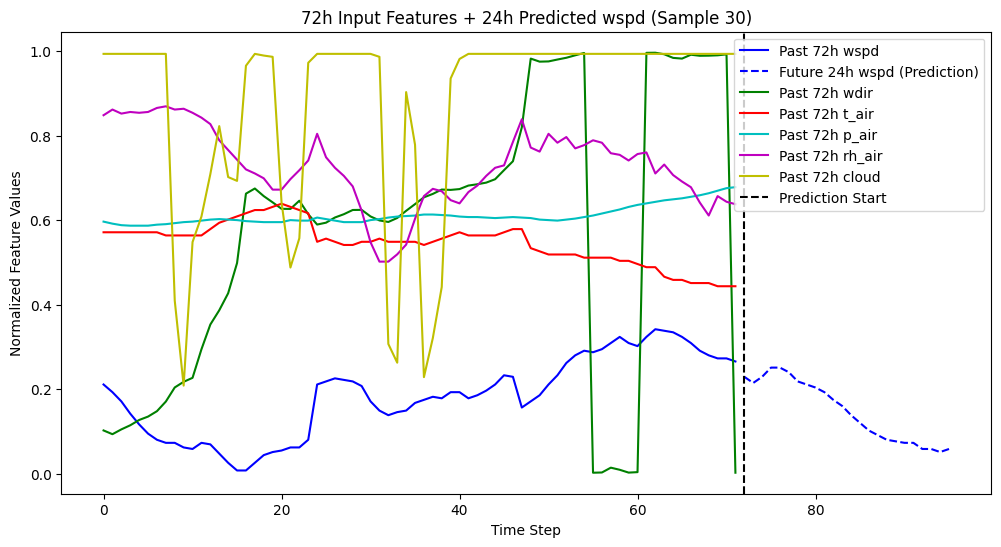

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Retrieve one sample from the dataset
sample_idx = np.random.randint(len(dataset))  # Pick a random sequence
sample_X, sample_Y = dataset[sample_idx]

# Convert to NumPy for plotting
sample_X = sample_X.numpy()
sample_Y = sample_Y.numpy()

# Extract feature names
feature_names = ['wspd', 'wdir', 't_air', 'p_air', 'rh_air', 'cloud']

# Extract the 72-hour past features
past_features = sample_X[:, :6]  # First 6 columns in X correspond to feature variables

# Create an empty array for future features (we only predict 'wspd')
future_features = np.full((24, 6), np.nan)  # Use NaN for missing future feature values
future_features[:, 0] = sample_Y  # Insert predicted 'wspd' into the future feature array

# Concatenate past 72-hour features with the 24-hour future wind speed predictions
full_features = np.vstack((past_features, future_features))

# Create time steps
time_steps = np.arange(full_features.shape[0])  # 96 points (72 past + 24 future)

# Define colors for each feature
colors = ['b', 'g', 'r', 'c', 'm', 'y']  # Blue, Green, Red, Cyan, Magenta, Yellow

# Plot all features on the same graph
plt.figure(figsize=(12, 6))

for i, feature in enumerate(feature_names):
    plt.plot(time_steps[:72], full_features[:72, i], label=f"Past 72h {feature}", color=colors[i], linestyle='solid')
    plt.plot(time_steps[72:], full_features[72:, i], label=f"Future 24h wspd (Prediction)" if feature == "wspd" else None, color=colors[i], linestyle='dashed')

# Mark the prediction point at t=72
plt.axvline(x=72, color='black', linestyle="--", label="Prediction Start")

plt.xlabel("Time Step")
plt.ylabel("Normalized Feature Values")
plt.title(f"72h Input Features + 24h Predicted wspd (Sample {sample_idx})")
plt.legend()
plt.show()


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split

# Define dataset split ratio
train_size = int(0.8 * len(dataset))  # 80% training
val_size = len(dataset) - train_size  # 20% validation

# Split dataset into training and validation sets
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
batch_size = 32  # Define batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [4]:
# Define the LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM Layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)

        # Fully Connected Output Layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state and cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)  # Hidden state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)  # Cell state

        # Forward pass through LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Take the last time step's output and pass through FC layer
        out = self.fc(out[:, -1, :])  # Only last time step output

        return out

# Model Hyperparameters
input_size = len(features + month_columns)  # Number of input features (including wspd and 1-hot encoded month)
hidden_size = 64  # LSTM hidden layer size
num_layers = 2  # Number of LSTM layers
output_size = 24  # Predicting next 24 hours of wspd

# Instantiate model
model = LSTMModel(input_size, hidden_size, num_layers, output_size).to("cuda" if torch.cuda.is_available() else "cpu")

# Define Loss Function and Optimizer
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Print Model Summary
print(model)


LSTMModel(
  (lstm): LSTM(17, 64, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=64, out_features=24, bias=True)
)


In [5]:
"""
# Define the BIG LSTM Model
class BigLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.3):
        super(BigLSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM Layer (Now Bi-directional)
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers,
            batch_first=True,
            dropout=dropout,
            bidirectional=True  # Makes it much more powerful
        )

        # Fully Connected Layers (MLP Head)
        self.fc1 = nn.Linear(hidden_size * 2, 256)  # Bidirectional LSTM output is twice hidden_size
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, output_size)  # Final output layer

        # Activation function
        self.relu = nn.ReLU()

    def forward(self, x):
        # Initialize hidden state and cell state
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)  # Multiply by 2 for bidirectional
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)

        # Forward pass through LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Take the last time step output
        out = out[:, -1, :]  # Last LSTM output

        # Pass through fully connected layers
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)  # Final prediction

        return out

# New Model Hyperparameters
input_size = len(features + month_columns)  # Number of input features (including wspd and 1-hot encoded month)
hidden_size = 512  # Increased LSTM hidden size
num_layers = 4  # More LSTM layers
output_size = 24  # Predicting next 24 hours of wspd

# Instantiate the large model
model = BigLSTMModel(input_size, hidden_size, num_layers, output_size).to("cuda" if torch.cuda.is_available() else "cpu")

# Define Loss Function and Optimizer
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Print Model Summary
print(model)
"""

'\n# Define the BIG LSTM Model\nclass BigLSTMModel(nn.Module):\n    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.3):\n        super(BigLSTMModel, self).__init__()\n        self.hidden_size = hidden_size\n        self.num_layers = num_layers\n\n        # LSTM Layer (Now Bi-directional)\n        self.lstm = nn.LSTM(\n            input_size, \n            hidden_size, \n            num_layers, \n            batch_first=True, \n            dropout=dropout, \n            bidirectional=True  # Makes it much more powerful\n        )\n\n        # Fully Connected Layers (MLP Head)\n        self.fc1 = nn.Linear(hidden_size * 2, 256)  # Bidirectional LSTM output is twice hidden_size\n        self.fc2 = nn.Linear(256, 128)\n        self.fc3 = nn.Linear(128, output_size)  # Final output layer\n\n        # Activation function\n        self.relu = nn.ReLU()\n\n    def forward(self, x):\n        # Initialize hidden state and cell state\n        h0 = torch.zeros(self.n

Epoch [1/100], Train Loss: 0.1240, Val Loss: 0.1310
Epoch [2/100], Train Loss: 0.1125, Val Loss: 0.1194
Epoch [3/100], Train Loss: 0.1017, Val Loss: 0.1074
Epoch [4/100], Train Loss: 0.0905, Val Loss: 0.0934
Epoch [5/100], Train Loss: 0.0775, Val Loss: 0.0758
Epoch [6/100], Train Loss: 0.0615, Val Loss: 0.0536
Epoch [7/100], Train Loss: 0.0425, Val Loss: 0.0329
Epoch [8/100], Train Loss: 0.0315, Val Loss: 0.0305
Epoch [9/100], Train Loss: 0.0357, Val Loss: 0.0262
Epoch [10/100], Train Loss: 0.0291, Val Loss: 0.0211
Epoch [11/100], Train Loss: 0.0230, Val Loss: 0.0226
Epoch [12/100], Train Loss: 0.0220, Val Loss: 0.0254
Epoch [13/100], Train Loss: 0.0233, Val Loss: 0.0261
Epoch [14/100], Train Loss: 0.0233, Val Loss: 0.0250
Epoch [15/100], Train Loss: 0.0220, Val Loss: 0.0232
Epoch [16/100], Train Loss: 0.0204, Val Loss: 0.0215
Epoch [17/100], Train Loss: 0.0198, Val Loss: 0.0205
Epoch [18/100], Train Loss: 0.0194, Val Loss: 0.0199
Epoch [19/100], Train Loss: 0.0190, Val Loss: 0.0197
Ep

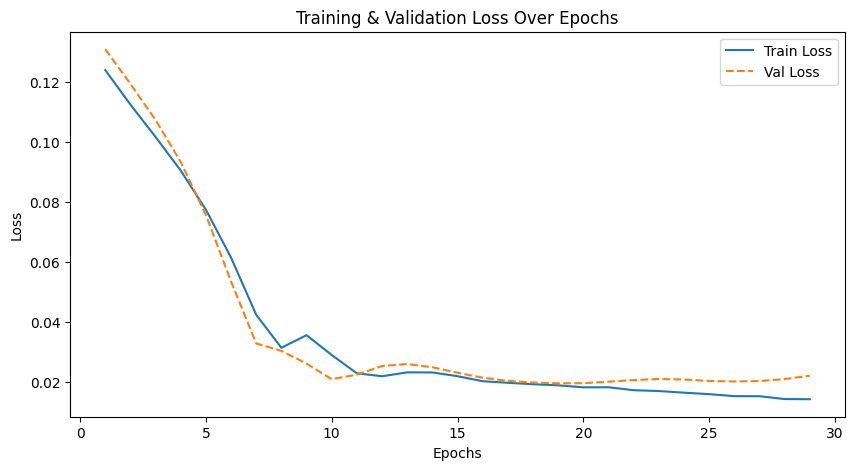

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to device
model.to(device)

# Define training parameters
num_epochs = 100  # Maximum number of epochs
patience = 10  # Early stopping patience
best_val_loss = float('inf')  # Track best validation loss
early_stop_counter = 0  # Count epochs without improvement

# Store loss values for visualization
train_losses = []
val_losses = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for batch_X, batch_Y in train_loader:
        batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)  # Move to GPU/CPU

        optimizer.zero_grad()  # Clear previous gradients
        outputs = model(batch_X)  # Forward pass
        loss = criterion(outputs, batch_Y)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        train_loss += loss.item()

    train_loss /= len(train_loader)  # Average loss per batch
    train_losses.append(train_loss)  # Store loss

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():  # No gradient updates in validation
        for batch_X, batch_Y in val_loader:
            batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_Y)
            val_loss += loss.item()

    val_loss /= len(val_loader)  # Average validation loss
    val_losses.append(val_loss)  # Store loss

    # Print training progress
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), "best_lstm_model.pth")  # Save best model
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping triggered. Training stopped.")
            break

# Plot Training & Validation Loss Curves
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Val Loss", linestyle="dashed")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss Over Epochs")
plt.legend()
plt.show()



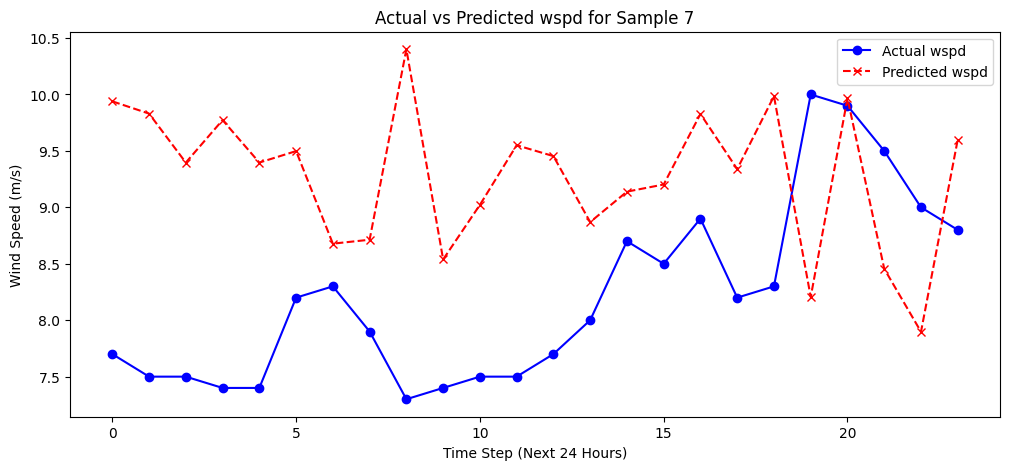

In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Load best model
model.load_state_dict(torch.load("best_lstm_model.pth"))
model.to(device)
model.eval()

# Function to make predictions on the validation set
def predict(model, val_loader):
    predictions = []
    actuals = []

    with torch.no_grad():
        for batch_X, batch_Y in val_loader:
            batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)
            outputs = model(batch_X)  # Model prediction

            predictions.append(outputs.cpu().numpy())  # Convert to numpy for plotting
            actuals.append(batch_Y.cpu().numpy())  # Ground truth values

    return np.vstack(predictions), np.vstack(actuals)  # Stack all batches together

# Get predictions and actual values
preds, actuals = predict(model, val_loader)

# Denormalize wspd predictions using the correct scaler
preds = scaler_Y.inverse_transform(preds)  # Only wspd is transformed
actuals = scaler_Y.inverse_transform(actuals)  # Only wspd is transformed


# Select a random sample from the validation set to visualize
sample_idx = np.random.randint(len(preds))

# Plot actual vs predicted wspd for a single sample
plt.figure(figsize=(12, 5))
plt.plot(range(24), actuals[sample_idx], label="Actual wspd", color='blue', marker='o')
plt.plot(range(24), preds[sample_idx], label="Predicted wspd", color='red', linestyle='dashed', marker='x')

plt.xlabel("Time Step (Next 24 Hours)")
plt.ylabel("Wind Speed (m/s)")
plt.title(f"Actual vs Predicted wspd for Sample {sample_idx}")
plt.legend()
plt.show()
